#Medical Insurance Cost Predictor

**Student Name:** Mst. Tahmina Jerin Arju

**Email: mst.tahminajerinarju@gmail.com**

**Dataset:** Medical Insurance Cost Prediction  
**Source:** https://www.kaggle.com/datasets/mirichoi0218/insurance

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## TASK 1: DATA LOADING (5 Marks)

In [3]:
# Load the dataset
data=pd.read_csv('/content/drive/MyDrive/AI ML Batch 1 Phitron/Machine Learning/Final_Exam/insurance.csv')

# Display first few rows
display(data.head())

# Display shape
print("\nDataset Shape:",data.shape)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520



Dataset Shape: (1338, 7)


## TASK 2: DATA PREPROCESSING (10 Marks)




In [4]:
# Preprocessing Step 1: Check for missing values
print("Missing Values Check:")
print(data.isnull().sum())

Missing Values Check:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


No missing values found in the dataset.

In [5]:
# Preprocessing Step 2:  Encoding categorical variables (sex,Amoker,region)
# Create a copy for preprocessing
data_processed=data.copy()

# Encode 'sex' column
le_sex =LabelEncoder()
data_processed['sex']=le_sex.fit_transform(data_processed['sex'])

# Encode 'smoker' column
le_smoker = LabelEncoder()
data_processed['smoker']=le_smoker.fit_transform(data_processed['smoker'])

# Encode 'regiion' column
le_region=LabelEncoder()
data_processed['region']=le_region.fit_transform(data_processed['region'])

print("\nEncoded data:")
display(data_processed.head())


Encoded data:


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [6]:
# Preprocessing Step 3:Feature Scaling
# Separate features and target
X = data_processed.drop('charges',axis=1)
y = data_processed['charges']

# Scale the features
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

print(f"Original feature range (age): {X['age'].min()} to {X['age'].max()}")
print(f"Scaled feature range (age): {X_scaled[:, 0].min():.2f} to {X_scaled[:, 0].max():.2f}")

Original feature range (age): 18 to 64
Scaled feature range (age): -1.51 to 1.77


Number of outliers detected: 139

Outlier range: Below -13109.15 or Above 34489.35


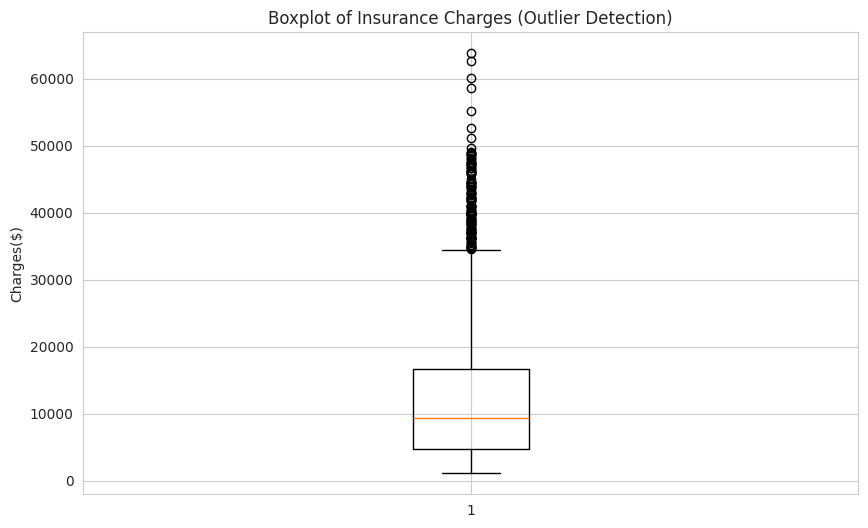

In [7]:
# Preprocessing Step 4:Outlier Detection using IQR method
Q1=data['charges'].quantile(0.25)
Q3=data['charges'].quantile(0.75)
IQR= Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound= Q3 + 1.5 * IQR

outliers = data[(data['charges'] < lower_bound) | (data['charges'] > upper_bound)]

print(f"Number of outliers detected: {len(outliers)}")
print(f"\nOutlier range: Below {lower_bound:.2f} or Above {upper_bound:.2f}")

# Visualize with boxplot
plt.figure(figsize=(10,6))
plt.boxplot(data['charges'])
plt.title('Boxplot of Insurance Charges (Outlier Detection)')
plt.ylabel('Charges($)')
plt.show()


Age group distribution:
age_group
0    306
1    395
2    421
3    216
Name: count, dtype: int64


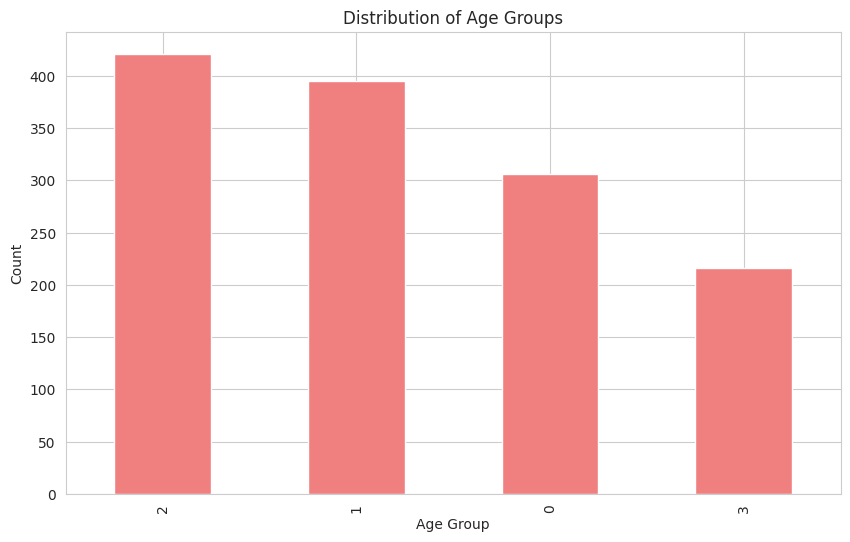

In [8]:
# Preprocessing Step 5:Feature Engineering -Create age groupss
data_processed['age_group'] = pd.cut(data_processed['age'],
                                      bins=[0, 25, 40, 55, 100],
                                      labels=[0, 1, 2, 3])
data_processed['age_group'] = data_processed['age_group'].astype(int)

print("\nAge group distribution:")
print(data_processed['age_group'].value_counts().sort_index())
data_processed.head()


# Visualize
plt.figure(figsize=(10, 6))
data_processed['age_group'].value_counts().plot(kind='bar',color='lightcoral')
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

Here, Age groiup means:
- 0: 0-25 years
- 1: 26-40 years
- 2: 41-55 years
- 3: 56+ years


In [9]:
data_processed.head()

,age,sex,bmi,children,smoker,region,charges,age_group
0,19,0,27.900,0,1,3,16884.92400,0
1,18,1,33.770,1,0,2,1725.55230,0
2,28,1,33.000,3,0,2,4449.46200,1
3,33,1,22.705,0,0,1,21984.47061,1
4,32,1,28.880,0,0,1,3866.85520,1


,charges
charges,1.000000
smoker,0.787251
age,0.299008
age_group,0.281691
bmi,0.198341
children,0.067998
sex,0.057292
region,-0.006208


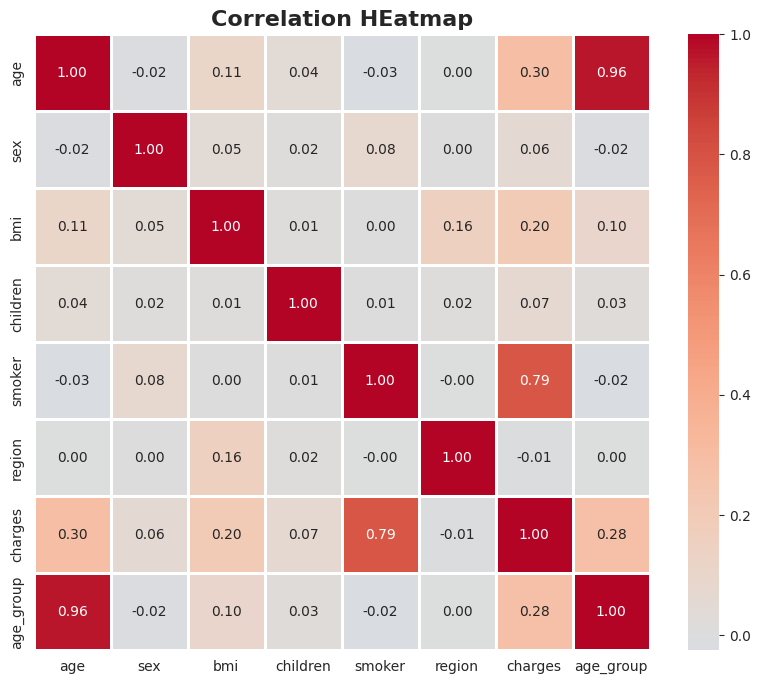

In [10]:
# Preprocessing Step 6:Correlation Analysis
# Calculate correlation matrix
correlation_matrix=data_processed.corr()

display(correlation_matrix['charges'].sort_values(ascending=False))

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm',center=0,
            fmt='.2f',square=True,linewidths=1)
plt.title('Correlation HEatmap',fontsize=16,fontweight='bold')
plt.show()

Smoking status is most important factor to predict insurance cost.

## Task 3: Pipeline Creation (10 Marks)

In [11]:
# Creat final features and target
X_final=data_processed.drop('charges',axis=1)
y_final=data_processed['charges']

# Split data into training and testing sets
X_train,X_test,y_train,y_test =train_test_split(X_final,y_final,test_size=0.2,random_state=42)

# Create pipeline
pipeline=Pipeline([
    ('scaler',StandardScaler()),
    ('model',RandomForestRegressor(random_state=42))
])

print(f"Training set size:{len(X_train)}")
print(f"Testing set size:{len(X_test)}")

Training set size:1070
Testing set size:268


## Task 4: Primary Model Selection (5 Marks)

Random Forest works well with numerical and categorical data.It can handle non-linear relationships like age,BMI ands smoking.It can handle outliers well and gives good accuracy without much tuning.


## Task 5: Model Training (10 Marks)

In [14]:
# Train the model use pipeline
pipeline.fit(X_train,y_train)

# Make predictions on training set
y_train_pred=pipeline.predict(X_train)

# Calculateion training score
train_r2=r2_score(y_train,y_train_pred)
train_rmse=np.sqrt(mean_squared_error(y_train,y_train_pred))

print(f"Training Set Performance:")
print(f"R2 Score: {train_r2:.4f}")
print(f"RMSE: ${train_rmse:.2f}")

Training Set Performance:
R2 Score: 0.9746
RMSE: $1914.84


## Task 6: Cross-Validation (10 Marks)

In [15]:
# Perform 5-fold cross-validation
cv_scores =cross_val_score(pipeline,X_train,y_train,
                           cv=5,
                           scoring='r2')

print("Cross-Validation Results:")
print(f"\nAverage R2 Score:{cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Cross-Validation Results:

Average R2 Score:0.8254
Standard Deviation: 0.0410


This shows our model is 82.54% accurate on average

## Task 7: Hyperparameter Tuning (10 Marks)

In [16]:
# Define parameter grid
param_grid = {
    'model__n_estimators':[50, 100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10]
}

# Display parameters tested
print("Parameters tested:",param_grid)

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3,
                          scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best results
print("\nBest Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Parameters tested: {'model__n_estimators': [50, 100, 200], 'model__max_depth': [10, 20, None], 'model__min_samples_split': [2, 5, 10]}

Best Parameters: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Best Score: 0.8362625960823339


## Task 8: Best Model Selection (10 Marks)

In [17]:
# Select the best model from grid search
best_model = grid_search.best_estimator_

print(f"Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")



Best Parameters:
  model__max_depth: 10
  model__min_samples_split: 10
  model__n_estimators: 200


This model achieved the best performance during hyperparameter tuning

## Task 9: Model Performance Evaluation (10 Marks)


R2 Score: 0.8696

Mean Absolute Error (MAE): 2523.00

Mean Squared Error (MSE): 20246652.59

Root Mean Squared Error (RMSE): 4499.63

SSome sample Predictions vs Actual Values:


,Actual,Predicted,Difference
0,9095.06825,10428.299501,-1333.231251
1,5272.17580,5201.432187,70.743613
2,29330.98315,27477.941679,1853.041471
3,9301.89355,9933.592061,-631.698511
4,33750.29180,34820.124862,-1069.833062
5,4536.25900,7967.672770,-3431.413770
6,2117.33885,2122.747797,-5.408947
7,14210.53595,14430.052822,-219.516872
8,3732.62510,7203.874928,-3471.249828
9,10264.44210,11131.907957,-867.465857


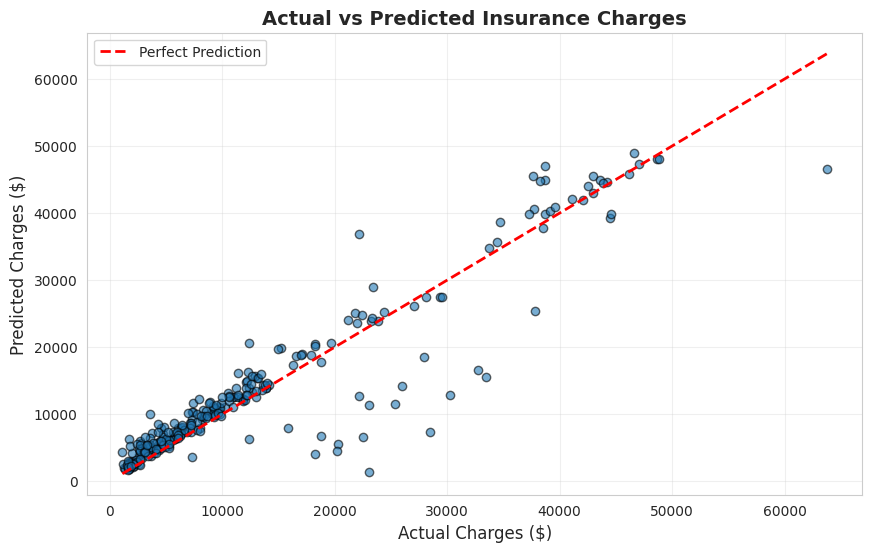

In [18]:
# Make predictions on test set
y_pred=best_model.predict(X_test)

# Calculate metrics
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
rmse =np.sqrt(mse)
r2=r2_score(y_test,y_pred)

print(f"\nR2 Score: {r2:.4f}")
print(f"\nMean Absolute Error (MAE): {mae:.2f}")
print(f"\nMean Squared Error (MSE): {mse:.2f}")
print(f"\nRoot Mean Squared Error (RMSE): {rmse:.2f}")

#  some sample predictions
print("\nSSome sample Predictions vs Actual Values:")
comparison=pd.DataFrame({
    'Actual':y_test.head(10).values,
    'Predicted':y_pred[:10],
    'Difference':y_test.head(10).values - y_pred[:10]
})
display(comparison)


# Actual vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test,y_pred,alpha=0.6,edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],'r--', lw=2,label='Perfect Prediction')
plt.xlabel('Actual Charges ($)', fontsize=12)
plt.ylabel('Predicted Charges ($)', fontsize=12)
plt.title('Actual vs Predicted Insurance Charges',fontsize=14,fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [19]:
# Save the best model
with open('/content/drive/MyDrive/AI ML Batch 1 Phitron/Machine Learning/Final_Exam/best_insurance_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Model saved successfully!")

Model saved successfully!
